In [2]:
import amigo
from amigo.optical_models import AMIOptics
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import dLux.utils as dlu
import dLux as dl

# Basic jax import
jax.config.update("jax_enable_x64", True)


from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

plt.rcParams["image.origin"] = 'lower'

# import alpha cen
from dLuxToliman import AlphaCen, TolimanOpticalSystem
import zodiax as zdx

In [8]:
# I wonder if I can make it a dLux telescope?
# from F480M filter
wlweights = np.array([[4.58283333e-06, 4.64250000e-06, 4.70216667e-06, 4.76183333e-06,
        4.82150000e-06, 4.88116667e-06, 4.94083333e-06, 5.00050000e-06,
        5.06016667e-06],
       [4.83897537e-03, 4.27569626e-02, 1.79674591e-01, 1.84285712e-01,
        2.00072602e-01, 1.85606063e-01, 1.65577628e-01, 3.61394316e-02,
        1.04803396e-03]])

# just a bunch of wavelengths
wavelengths = wlweights[0]
weights = wlweights[1]

# let us instead make a polynomial spectrum
# of the form wavelengths, coefficients
# this will double the spectral weight over the bandpass
spec_C = 1 #-8.54
spec_grad = 0 #2083333
spectrum = dl.PolySpectrum(wavelengths, np.array([spec_C,spec_grad]))
# try extracting the AMI optics and putting it into a normal dlux system.. this is SO JANK

optics = AMIOptics(filters=["F480M"])

In [9]:
print(optics)

AMIOptics(
  wf_npixels=1024,
  diameter=6.603464,
  layers={
    'InvertY': Flip(axes=0),
    'pupil_mask':
    StaticApertureMask(
      transmission=f64[1024,1024],
      normalise=True,
      abb_basis=f64[7,10,180,180],
      abb_coeffs=f64[7,10],
      amp_basis=f64[7,10,180,180],
      amp_coeffs=f64[7,10],
      corners=i64[7,2]
    )
  },
  psf_npixels=80,
  oversample=3,
  psf_pixel_scale=0.065524085,
  filters={'F480M': f64[2,9]},
  defocus_type='fft',
  defocus=f64[],
  corners=i64[7,2],
  psf_upsample=3
)


In [10]:
log_fluxes = np.linspace(7,10,4)

flux = 10**(log_fluxes[0]) #6.016
# binary source,
# going to have to import alpha cen because it has individial x and y position ? no
# source = AlphaCen(wavelengths=wavelengths, log_flux=np.log10(flux))
separation = 2*4.80e-6/6.603464 # lambda/d separation

# 100:1 contrast ratio?
contrast = 100
source = dl.BinarySource(spectrum=spectrum, position=dlu.arcsec2rad(np.array([0,0])), 
                        mean_flux=flux, separation=separation, position_angle=np.pi/2, contrast=contrast)

## could just make a new point source
# source = dl.PointSource(wavelengths=wavelengths, position = dlu.arcsec2rad(np.array([0,0])), flux = flux)

# optional detector
detector_layers = [
    (
        'downsample',
        dl.detector_layers.Downsample(3)
    )
]
detector = dl.LayeredDetector(detector_layers)

# setting up the dithers

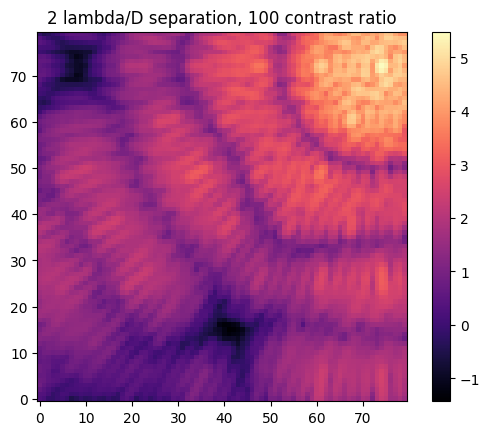

maximum photoelectron count:
302587.21878232143


In [11]:
# alright this is looking good!
r_star = 3
angle = np.pi/4
radial_dist = r_star #arcsec

x_dither = radial_dist * np.cos(angle)
y_dither = radial_dist * np.sin(angle)
dithers = dlu.arcsec2rad(np.array([[x_dither,-y_dither]]))
model = dl.Dither(dithers, optics, source, detector)

data = model.model()

plt.imshow(np.log10(data[0]), origin='lower', cmap='magma')
plt.colorbar()
plt.title('2 lambda/D separation, 100 contrast ratio')
plt.show()
print('maximum photoelectron count:')
print(np.max(data))

In [12]:
print(model)

Dither(
  optics=AMIOptics(
    wf_npixels=1024,
    diameter=6.603464,
    layers={
      'InvertY': Flip(axes=0),
      'pupil_mask':
      StaticApertureMask(
        transmission=f64[1024,1024],
        normalise=True,
        abb_basis=f64[7,10,180,180],
        abb_coeffs=f64[7,10],
        amp_basis=f64[7,10,180,180],
        amp_coeffs=f64[7,10],
        corners=i64[7,2]
      )
    },
    psf_npixels=80,
    oversample=3,
    psf_pixel_scale=0.065524085,
    filters={'F480M': f64[2,9]},
    defocus_type='fft',
    defocus=f64[],
    corners=i64[7,2],
    psf_upsample=3
  ),
  source=BinarySource(
    spectrum=PolySpectrum(wavelengths=f64[9], coefficients=f64[2]),
    position=f64[2],
    mean_flux=10000000.0,
    separation=1.4537824390350277e-06,
    position_angle=1.5707963267948966,
    contrast=100.0
  ),
  detector=LayeredDetector(layers={'downsample': Downsample(kernel_size=3)}),
  dithers=f64[1,2]
)


In [14]:
# nah too bad this breaks...
from amigo.fisher import FIM
# # parameters
marginal_params = ['separation', 'position_angle', 'mean_flux', 'contrast', 'spectrum.coefficients', 'position']
# marginalise over mean wavelength ..??? ??
# unnecessary I think to marginalise over mean wavelength.. 
# shape_dict = {'coefficients': (1,)}

fisher_full = FIM(model, marginal_params, poiss_loglike, data=data)# , shape_dict=shape_dict)

keep_idx = np.array([0,1,2,3,5,6,7]) # skip the fourth index
fisher = fisher_full[np.ix_(keep_idx, keep_idx)]

cov = np.linalg.inv(fisher)

E1022 18:27:00.146817 1147877 slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reduce-window = f64[1,2,9,32,32]{4,3,2,1,0} reduce-window(%broadcast.1292, %constant.9946), window={size=1x1x1x32x32 stride=1x1x1x32x32}, to_apply=%region_10.14

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
E1022 18:27:04.207785 1147711 slow_operation_alarm.cc:140] The operation took 5.065981s
Constant folding an instruction is taking > 1s:

  %reduce-window = f64[1,2,9,32,32]{4,3,2,1,0} reduce-window(%broadcast.1292, %constant.9946), window={size=1x1x1x32x32 stride=1x1x1x32x32}, to_apply=%region_10.14

This isn't necessarily a b

XlaRuntimeError: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "/Users/milolangker/anaconda3/envs/amgioenv/lib/python3.11/site-packages/jax/_src/callback.py", line 784, in _wrapped_callback
  File "/Users/milolangker/anaconda3/envs/amgioenv/lib/python3.11/site-packages/jax/_src/callback.py", line 223, in _callback
  File "/Users/milolangker/anaconda3/envs/amgioenv/lib/python3.11/site-packages/jax/_src/callback.py", line 95, in pure_callback_impl
  File "/Users/milolangker/anaconda3/envs/amgioenv/lib/python3.11/site-packages/jax/_src/callback.py", line 70, in __call__
  File "/Users/milolangker/anaconda3/envs/amgioenv/lib/python3.11/site-packages/equinox/_errors.py", line 88, in raises
_EquinoxRuntimeError: A linear solver received non-finite (NaN or inf) input and cannot determine a 
solution. 

This means that you have a bug upstream of Lineax and should check the inputs to 
`lineax.linear_solve` for non-finite values.


--------------------
An error occurred during the runtime of your JAX program! Unfortunately you do not appear to be using `equinox.filter_jit` (perhaps you are using `jax.jit` instead?) and so further information about the error cannot be displayed. (Probably you are seeing a very large but uninformative error message right now.) Please wrap your program with `equinox.filter_jit`.
--------------------
